In [6]:
from PIL import Image
import os
import multiprocessing
from functools import partial
import logging
import progressbar
logging.basicConfig(level=logging.INFO)
import numpy as np

In [33]:
def normalize_mask(im):
    return (im > 127).astype(np.uint8)

In [31]:
def dice_coef(x, y):
    xf = x.ravel()
    yf = y.ravel()
    intersection = np.sum(xf * yf)
    return (2. * intersection) / (np.sum(x) + np.sum(y))

In [46]:
def evaluate_interpolation(img, target_size=(240, 160)):
    interpolations = {"area": cv2.INTER_AREA,
                      "cubic": cv2.INTER_CUBIC,
                      "lanczos": cv2.INTER_LANCZOS4,
                      "nn": cv2.INTER_NEAREST,
                      "linear": cv2.INTER_LINEAR}
    results = []
    original_size = img.shape[:2][::-1]
    for down_name, down_interp in interpolations.items():
        for up_name, up_interp in interpolations.items():
            img_copy = img.copy()
            img_copy *= 255
            img_down = cv2.resize(img_copy, target_size, interpolation=down_interp)
            img_up = cv2.resize(img_down, original_size, interpolation=up_interp)
            score = dice_coef(img, normalize_mask(img_up))
            results.append(((down_name, up_name), score))
    return results

In [47]:
m = np.array(Image.open("../data/train_masks_sample/03a857ce842d_11_mask.gif"))

In [48]:
results = evaluate_interpolation(m)

In [50]:
sorted(results, key=lambda x: x[1])

[(('nn', 'nn'), 0.98688279737565865),
 (('nn', 'area'), 0.98722410563784424),
 (('nn', 'lanczos'), 0.98757727618610225),
 (('nn', 'cubic'), 0.98765376506580183),
 (('nn', 'linear'), 0.9877059924165783),
 (('lanczos', 'nn'), 0.99290942504783686),
 (('cubic', 'nn'), 0.99291648841555402),
 (('cubic', 'area'), 0.99295365517315926),
 (('lanczos', 'area'), 0.99295563265449605),
 (('linear', 'nn'), 0.99295697952078654),
 (('linear', 'area'), 0.99300972516922048),
 (('area', 'nn'), 0.99303501058400834),
 (('area', 'area'), 0.99336384253790444),
 (('cubic', 'lanczos'), 0.99479376332291369),
 (('linear', 'lanczos'), 0.99486588347599769),
 (('cubic', 'cubic'), 0.99487561893337229),
 (('cubic', 'linear'), 0.99488642199090804),
 (('lanczos', 'lanczos'), 0.99490181421926427),
 (('linear', 'cubic'), 0.99493058713869509),
 (('lanczos', 'linear'), 0.99493230003306388),
 (('lanczos', 'cubic'), 0.9949412301897872),
 (('linear', 'linear'), 0.99497592461634787),
 (('area', 'linear'), 0.99770110802451073),


In [108]:
m = Image.open("../data/train_masks_sample/03a857ce842d_11_mask.gif")

In [109]:
m = Image.fromarray(np.array(m) * 255)

In [114]:
%timeit m.resize((1920//2, 1280//2), resample=Image.LANCZOS)

10 loops, best of 3: 20 ms per loop


In [52]:
m.size

(1918, 1280)

In [121]:
1920//2

960

In [122]:
1280//2

640

In [79]:
from collections import defaultdict

In [115]:
def evaluate_interpolation(imgs, target_size=(240, 160)):
    interpolations = {"pil_area": Image.BOX,
                      "pil_cubic": Image.BICUBIC,
                      "pil_lanczos": Image.LANCZOS,
                      "pil_nn": Image.NEAREST,
                      "pil_linear": Image.BILINEAR,
                      "pil_hamming": Image.HAMMING,
                      "cv2_area": cv2.INTER_AREA,
                      "cv2_cubic": cv2.INTER_CUBIC,
                      "cv2_lanczos": cv2.INTER_LANCZOS4,
                      "cv2_nn": cv2.INTER_NEAREST,
                      "cv2_linear": cv2.INTER_LINEAR}
    results = defaultdict(float)
    for img in imgs:
        original_size = img.shape[:2][::-1]
        for down_name, down_interp in interpolations.items():
            for up_name, up_interp in interpolations.items():
                img_copy = img.copy()
                if "cv2" in down_name:
                    img_copy *= 255
                    img_down = cv2.resize(img_copy, target_size, interpolation=down_interp)
                else:
                    img_copy = Image.fromarray(img_copy * 255)
                    img_down = img_copy.resize(target_size, resample=down_interp)
                    img_down = np.array(img_down)

                if "cv2" in up_name:
                    img_up = cv2.resize(img_down, original_size, interpolation=up_interp)
                else:
                    img_down = Image.fromarray(img_down)
                    img_up = img_down.resize(original_size, resample=up_interp)
                    img_up = np.array(img_up)

                score = dice_coef(np.array(img), normalize_mask(np.array(img_up)))
                results[(down_name, up_name)] += score
    return results

In [116]:
def iter_files_with_ext(root_dir, ext):
    """
    Iterate recursively on all files in root dir, ending with <ext>.
    :param root_dir: Directory to list.
    :param ext: Extension of the files.
    :return: absolute path of all files.
    """
    for path, sub_dirs, files in os.walk(root_dir):
        for name in files:
            if not name.startswith(".") and name.endswith(ext):
                abs_path = os.path.abspath(os.path.join(path, name))
                if os.path.isfile(abs_path):
                    yield os.path.join(path, name)

In [117]:
gifs = iter_files_with_ext("../data/train_masks_sample/", ".gif")

In [118]:
imgs = []
for fn in gifs:
    imgs.append(np.array(Image.open(fn)))

In [119]:
results = evaluate_interpolation(imgs, (1920//2, 1280//2))

In [120]:
sorted(results.items(), key=lambda x: x[1])

[(('cv2_nn', 'cv2_nn'), 9.9707585974039841),
 (('cv2_nn', 'pil_nn'), 9.9773067484345397),
 (('cv2_nn', 'cv2_area'), 9.9773100316542784),
 (('cv2_nn', 'pil_area'), 9.9773320790207514),
 (('cv2_nn', 'pil_hamming'), 9.977807474608273),
 (('cv2_nn', 'pil_cubic'), 9.9780518524368418),
 (('cv2_nn', 'pil_lanczos'), 9.9781641177148366),
 (('cv2_nn', 'cv2_lanczos'), 9.978208036173088),
 (('cv2_nn', 'cv2_linear'), 9.9782879999554659),
 (('cv2_nn', 'cv2_cubic'), 9.9783109202617606),
 (('cv2_nn', 'pil_linear'), 9.978316242011152),
 (('pil_area', 'cv2_nn'), 9.9809971551820205),
 (('pil_nn', 'pil_area'), 9.9819997605731068),
 (('pil_nn', 'pil_nn'), 9.982020608708563),
 (('pil_nn', 'cv2_area'), 9.9820222607948015),
 (('pil_nn', 'cv2_nn'), 9.9820292461466718),
 (('cv2_lanczos', 'cv2_nn'), 9.9820317389774846),
 (('cv2_cubic', 'cv2_nn'), 9.9820461738402866),
 (('pil_nn', 'pil_hamming'), 9.9825838180393092),
 (('cv2_linear', 'cv2_nn'), 9.9827833729666384),
 (('pil_lanczos', 'cv2_nn'), 9.9831149342314109)

In [8]:
%timeit Image.fromarray(np.array(m) * 255)

The slowest run took 14.97 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 3.02 ms per loop


In [9]:
import cv2

In [38]:
m = np.array(m) * 255

In [20]:
%timeit cv2.resize(m, (1920//2, 1280//2), interpolation=cv2.INTER_AREA)

100 loops, best of 3: 4.25 ms per loop


In [21]:
%timeit cv2.resize(m, (1920//2, 1280//2), interpolation=cv2.INTER_LINEAR)

The slowest run took 8.30 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 694 µs per loop


In [22]:
%timeit cv2.resize(m, (1920//2, 1280//2), interpolation=cv2.INTER_LANCZOS4)

100 loops, best of 3: 2.84 ms per loop


In [23]:
%timeit cv2.resize(m, (1920//2, 1280//2), interpolation=cv2.INTER_CUBIC)

1000 loops, best of 3: 1.11 ms per loop


In [25]:
cv2.imwrite("../data/im_cubic.png", cv2.resize(m, (1920//2, 1280//2), interpolation=cv2.INTER_CUBIC))

True

In [26]:
cv2.imwrite("../data/im_nn.png", cv2.resize(m, (1920//2, 1280//2), interpolation=cv2.INTER_NEAREST))

True

In [27]:
cv2.imwrite("../data/im_linear.png", cv2.resize(m, (1920//2, 1280//2), interpolation=cv2.INTER_LINEAR))

True

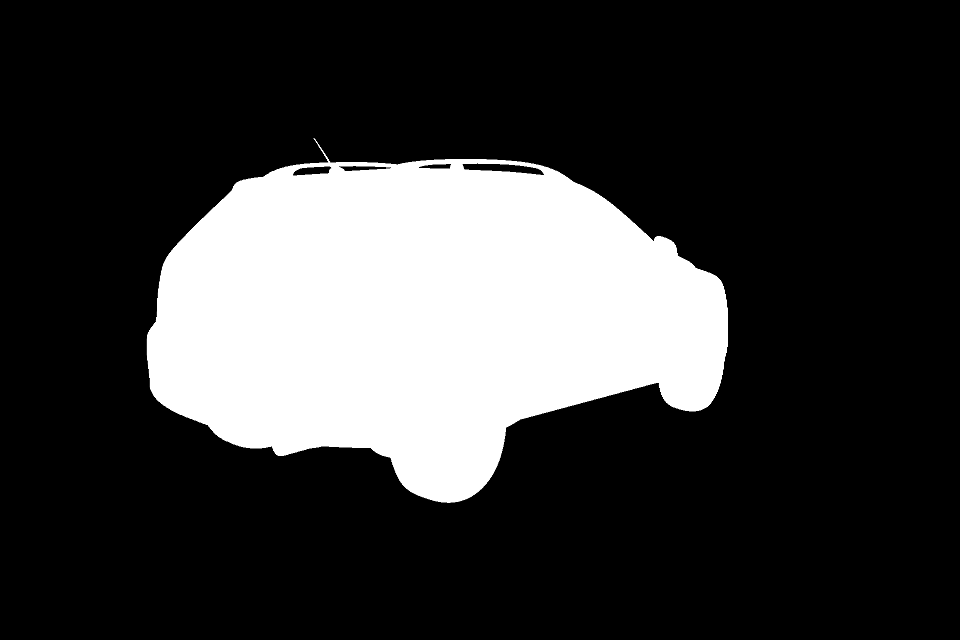

In [24]:
Image.fromarray(cv2.resize(m, (1920//2, 1280//2), interpolation=cv2.INTER_CUBIC))

In [2]:
logging.debug("Test debug")
logging.info("Test info")

INFO:root:Test info


In [3]:
def resize_worker(src_filename, dst_dir, target_size, is_boolean=False):
    try:
        img = Image.open(src_filename)
        resample_method = Image.NEAREST if is_boolean else Image.BICUBIC
        img_resized = img.resize(target_size, resample=resample_method)
        
        src_basename = os.path.basename(src_filename)
        dst_basename, _ = os.path.splitext(src_basename)
        dst_filename = os.path.join(dst_dir, dst_basename + ".png")
        img_resized.save(dst_filename)
    except Exception as e:
        logging.error("Can't process image {}: {}".format(src_filename, e))

In [4]:
def iter_files_with_ext(root_dir, ext):
    """
    Iterate recursively on all files in root dir, ending with <ext>.
    :param root_dir: Directory to list.
    :param ext: Extension of the files.
    :return: absolute path of all files.
    """
    for path, sub_dirs, files in os.walk(root_dir):
        for name in files:
            if not name.startswith(".") and name.endswith(ext):
                abs_path = os.path.abspath(os.path.join(path, name))
                if os.path.isfile(abs_path):
                    yield os.path.join(path, name)

In [5]:
def resize_all(src_dir, src_ext, dst_dir, target_size, is_boolean=False):
    os.makedirs(dst_dir, exist_ok=True)
    iter_images = iter_files_with_ext(src_dir, ext=src_ext)
    
    resize_worker_spec = partial(resize_worker, dst_dir=dst_dir, target_size=target_size, is_boolean=is_boolean)
    with multiprocessing.Pool() as pool, progressbar.ProgressBar(max_value=progressbar.UnknownLength) as pbar:
        for i, _ in enumerate(pool.imap_unordered(resize_worker_spec, iter_images)):
            pbar.update(i+1)

In [57]:
resize_all("../data/train/", ".jpg", "../data/train_240x160/", (240, 160), is_boolean=False)

| 5088 Elapsed Time: 0:01:34                                                   


In [59]:
resize_all("../data/test/", ".jpg", "../data/test_240x160/", (240, 160), is_boolean=False)

| 100064 Elapsed Time: 0:45:38                                                 


In [58]:
resize_all("../data/train_masks/", ".gif", "../data/train_masks_240x160/", (240, 160), is_boolean=True)

| 5088 Elapsed Time: 0:00:31                                                   


In [6]:
resize_all("../data/train/", ".jpg", "../data/train_480x320/", (480, 320), is_boolean=False)

| 5088 Elapsed Time: 0:02:17                                                   


In [7]:
resize_all("../data/train_masks/", ".gif", "../data/train_masks_480x320/", (480, 320), is_boolean=True)

| 5088 Elapsed Time: 0:00:40                                                   


In [8]:
resize_all("../data/test/", ".jpg", "../data/test_480x320/", (480, 320), is_boolean=False)

| 100064 Elapsed Time: 0:56:34                                                 


In [50]:
im = Image.open("../data/train_240x160/0d3adbbc9a8b_02.png")

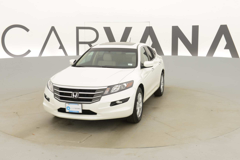

In [51]:
im

In [10]:
mask = Image.open("../data/train_masks_480x320/16f0ec26d608_07_mask.png")

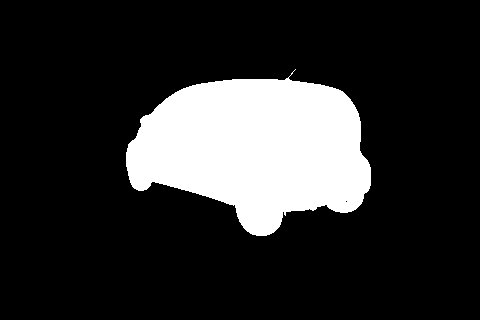

In [11]:
mask

In [54]:
import numpy as np

In [55]:
np.array(mask)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [56]:
np.max(mask)

1